# Import packages

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint as sp_randint

# Unpickle engineered features

In [25]:
unpickled_df = pd.read_pickle("./engineered_data.pkl")

# Mark each essay with its scoring scale

In [26]:
trainingdata = unpickled_df
DivSeries = pd.DataFrame({'div': [12,5,3,3,4,4,25,50],'essay_set':[1,2,3,4,5,6,7,8]})
trainingdata = trainingdata.merge(DivSeries, on='essay_set')
cols_at_end = ['score']
trainingdata = trainingdata[[c for c in trainingdata if c not in cols_at_end] + [c for c in cols_at_end if c in trainingdata]]
trainingdata = trainingdata.dropna()

# Split into train and test data

In [27]:
traincomp, testcomp = train_test_split(trainingdata,random_state=42,test_size=0.2)

set_train = traincomp.loc[:,['essay_set','essay_id','div']]  # setting asside essay set and scale
set_test = testcomp.loc[:,['essay_set','essay_id','div']] # setting asside essay set and scale

x_train = np.asarray(traincomp.iloc[:,:-3])
y_train = np.reshape(np.asarray(traincomp.loc[:,['score']]),(-1,))

x_test = np.asarray(testcomp.iloc[:,:-3])
y_test = np.reshape(np.asarray(testcomp.loc[:,['score']]),(-1,))

# Specify and fit models

In [28]:
lr = LinearRegression(fit_intercept=True)
rf = RandomForestRegressor(n_estimators=500, min_samples_split=10, min_samples_leaf=3, max_features='auto',max_depth=44, bootstrap=True, random_state=42)
sv = svm.SVR(kernel='rbf',C=0.1,gamma='scale')

In [29]:
lr.fit(x_train, y_train)
rf.fit(x_train, y_train)
sv.fit(x_train, y_train)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Define metrics for evaluation

In [30]:
def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

def evaluate(model, x_test, y_test, div, essay_set):
    predictions = model.predict(x_test)
    y_rescaled = y_test * div
    y_rescaled = y_rescaled.astype(int)
    predictions_rescaled = predictions * div
    predictions_round = predictions_rescaled.round()
    predictions_round = predictions_round.astype(int)
    rmse = RMSE(y_rescaled, predictions_round)
    cohen = cohen_kappa_score(y_rescaled, predictions_round, weights=None)
    quad_cohen = cohen_kappa_score(y_rescaled, predictions_round, weights='quadratic')
    accuracy = accuracy_score(y_rescaled, predictions_round)
    return {'rmse':rmse,'kappa':cohen,'quad_kappa':quad_cohen,'accuracy':accuracy}

# Score models

In [31]:
lr_metrics = evaluate(lr,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
rf_metrics = evaluate(rf,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
sv_metrics = evaluate(sv,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
print("Linear Regression RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(lr_metrics['rmse'], lr_metrics['kappa'],lr_metrics['quad_kappa'],lr_metrics['accuracy']))
print("Random Forests RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(rf_metrics['rmse'], rf_metrics['kappa'], rf_metrics['quad_kappa'],rf_metrics['accuracy']))
print("Support Vector RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(sv_metrics['rmse'], sv_metrics['kappa'],sv_metrics['quad_kappa'],sv_metrics['accuracy']))

Linear Regression RMSE: 2.02250435917868 Cohen Kappa: 0.4001262423530352 Cohen QW-Kappa: 0.9741565966034074 Accuracy: 0.4761171032357473
Random Forests RMSE: 1.5422903345729375 Cohen Kappa: 0.4665936551347196 Cohen QW-Kappa: 0.9843781904283819 Accuracy: 0.5342835130970724
Support Vector RMSE: 1.8743257647535838 Cohen Kappa: 0.40089386711048913 Cohen QW-Kappa: 0.9774461651725512 Accuracy: 0.4761171032357473


# Score models by essay set

In [33]:
rf_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],rf.predict(x_test)]).transpose()
rf_scoring_df.columns = ['actual','essay_set','div','prediction']

lr_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],lr.predict(x_test)]).transpose()
lr_scoring_df.columns = ['actual','essay_set','div','prediction']

sv_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],sv.predict(x_test)]).transpose()
sv_scoring_df.columns = ['actual','essay_set','div','prediction']

def essay_set_metrics(df):
    df['y_rescaled'] = df.actual * df['div']
    df.y_rescaled = df.y_rescaled.astype(int)
    df['prediction_rescaled'] = df.prediction * df['div']
    df['prediction_round'] = df.prediction_rescaled.round()
    df.prediction_round = df.prediction_round.astype(int)
    set_df = pd.DataFrame(columns=['essay_set','RMSE','Normalized RMSE','Kappa','QW_Kappa','Accuracy'])
    e_sets = np.unique(df.essay_set)
    for e_s in e_sets:
        df_s = df[df.essay_set == e_s]
        original_score = df_s.y_rescaled.values
        predicted_score = df_s.prediction_round.values
        rmse = RMSE(original_score,predicted_score)
        norm_rmse = RMSE(df_s.actual, df_s.prediction)
        kappa = cohen_kappa_score(original_score,predicted_score, weights=None)
        quad_kappa = cohen_kappa_score(original_score,predicted_score, weights='quadratic')
        accuracy = accuracy_score(original_score,predicted_score)
        set_df = set_df.append({'essay_set':e_s,'RMSE':rmse,'Normalized RMSE':norm_rmse,'Kappa':kappa,'QW_Kappa':quad_kappa,'Accuracy':accuracy},
                             ignore_index=True)
    return set_df


print(essay_set_metrics(lr_scoring_df))
print(essay_set_metrics(rf_scoring_df))
print(essay_set_metrics(sv_scoring_df))

   essay_set      RMSE  Normalized RMSE     Kappa  QW_Kappa  Accuracy
0        1.0  1.113749         0.089623  0.185354  0.655447  0.374317
1        2.0  0.685994         0.125353  0.341279  0.567920  0.598930
2        3.0  0.689962         0.208260  0.338168  0.541992  0.577844
3        4.0  0.679052         0.209461  0.364771  0.599695  0.586111
4        5.0  0.623222         0.144039  0.438439  0.726207  0.620290
5        6.0  0.755929         0.176397  0.275904  0.543264  0.558201
6        7.0  3.162278         0.125698  0.049620  0.698724  0.115894
7        8.0  6.778024         0.133548  0.032291  0.359403  0.080292
   essay_set      RMSE  Normalized RMSE     Kappa  QW_Kappa  Accuracy
0        1.0  0.837965         0.064856  0.337357  0.813753  0.500000
1        2.0  0.573478         0.104128  0.525508  0.697749  0.708556
2        3.0  0.670151         0.192519  0.427363  0.609564  0.628743
3        4.0  0.654047         0.188725  0.451525  0.696475  0.627778
4        5.0  0.5946

# Mean quadratic weighted kappa

In [34]:
print("Linear Regression Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(lr_scoring_df)['QW_Kappa']))
print("Random Forest Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(rf_scoring_df)['QW_Kappa']))
print("Support Vector Regression Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(sv_scoring_df)['QW_Kappa']))

Linear Regression Average Quadratic Weighted Kappa  0.5865813419549195
Random Forest Average Quadratic Weighted Kappa  0.7072280620879919
Support Vector Regression Average Quadratic Weighted Kappa  0.5624911498540449


# Feature importance

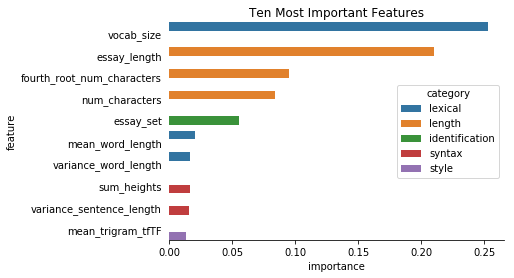

In [139]:
import pylab as plt
import seaborn as sns


feature_dict = {
    'lexical':['words_length_4','words_length_6','words_length_8','words_length_10','words_length_12','mean_word_length','variance_word_length','type_token_ratio','vocab_size'],
    'length':['essay_length','num_words','num_sentences','mean_sentence_length','num_characters','fourth_root_num_characters'],
    'occurence':['num_commas','num_periods','num_exclaim','num_question','num_semicolon','num_colon'],
    'style':['mean_trigram_tfTF', 'mean_fourgram_tfTF','pos_trigram_ratio','pos_fourgram_ratio','yules_k','connectives'],
    'syntax':['max_height','var_height','very_short_sentences','short_sentences','medium_sentences','long_sentences','variance_sentence_length','max_height','sum_heights','mean_height'],
    'reading_score':['flesch_kincaid_grade_level', 'flesch_reading_ease','gunning_fog_index', 'coleman_liau_index','automated_readability_index', 'lix', 'gulpease_index','wiener_sachtextformel'],
    'identification':['essay_set']
               }
d = dict()
for key, value in feature_dict.items():
    for item in value:
        d[item] = key
    
feature_importances = pd.DataFrame(rf.feature_importances_, index = trainingdata.columns[:-3], columns=['importance']).sort_values('importance',ascending=False)
feature_importances['rank'] = np.argsort(-feature_importances.importance)
feature_importances['feature'] = feature_importances.index
feature_importances['category'] = feature_importances['feature'].map(d)
feature_plot_data = feature_importances[feature_importances['rank'] < 10]
feature_plot_data



fig, ax = plt.subplots()

g = sns.barplot(x='importance', y='feature', hue='category', ax=ax, data=feature_plot_data)
# g = sns.catplot(x='importance', y='feature', hue='category', data=feature_plot_data,
#                 height=5, kind="bar")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)
plt.title("Ten Most Important Features")
sns.despine(left=True)
ax.yaxis.set_ticks_position('none') 

plt.show()

fig = g.figure
fig.savefig('feature_importance.png' ,bbox_inches="tight")


# Grid search code (commented out for brevity)

In [ ]:
# # # Create the parameter grid based on the results of random search 
# param_grid = {
#     'n_estimators': [500],
#     'min_samples_split': [10, 12],
#     'min_samples_leaf': [2,3],
#     'max_features': ['auto'],
#     'max_depth': [40, 44],
#     'bootstrap': [True]  
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(x_train, y_train)

In [10]:
# grid = {
#     'kernel': ['linear','rbf'],
#     'gamma': ['auto'],
#     'C':[0.1,1]
# }

# sv = svm.SVR()

# sv_grid = GridSearchCV(estimator = sv, param_grid= grid, cv = 3, verbose=4, n_jobs = -1)
# sv_grid.fit(x_train, y_train)